In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install unidecode
# !pip install -r requirements.txt


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\aisha\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
import yaml
from pathlib import Path
import torch
from torch.utils.data import DataLoader, ConcatDataset, Subset
from emg2qwerty.data import WindowedEMGDataset
from emg2qwerty.transforms import Compose, ToTensor, LogSpectrogram, SpecAugment, RandomBandRotation, TemporalAlignmentJitter


batch_size = 32
num_workers = 2

# 1. Load the configuration file
config_path = Path("config/user/single_user.yaml")
with open(config_path, 'r') as f:
    first_line = f.readline()
    if first_line.startswith('# @package'):
        cfg = yaml.safe_load(f)
    else:
        f.seek(0)
        cfg = yaml.safe_load(f)

# 2. Set the data root path
data_root = Path("data")

# 3. Create transforms
# Training transforms with augmentation
train_transform = Compose([
    ToTensor(),
    LogSpectrogram(),
    SpecAugment(),
    RandomBandRotation()
])

# Validation/test transforms without augmentation
eval_transform = Compose([
    ToTensor(),
    LogSpectrogram()
])

# 4. Create datasets
train_datasets = []
for session_info in cfg['dataset']['train']:
    session_id = session_info['session']
    file_path = data_root / f"{session_id}.hdf5"

    dataset = WindowedEMGDataset(
        hdf5_path=file_path,
        window_length=2000,  # 1 second at 2kHz
        stride=1000,         # 50% overlap
        padding=(200, 200),  # 100ms context on each side
        jitter=True,         # Apply jitter for training
        transform=train_transform
    )
    train_datasets.append(dataset)

val_datasets = []
for session_info in cfg['dataset']['val']:
    session_id = session_info['session']
    file_path = data_root / f"{session_id}.hdf5"

    dataset = WindowedEMGDataset(
        hdf5_path=file_path,
        window_length=2000,
        stride=1000,
        padding=(200, 200),
        jitter=False,  # No jitter for validation
        transform=eval_transform
    )
    val_datasets.append(dataset)

test_datasets = []
for session_info in cfg['dataset']['test']:
    session_id = session_info['session']
    file_path = data_root / f"{session_id}.hdf5"

    dataset = WindowedEMGDataset(
        hdf5_path=file_path,
        window_length=2000,
        stride=1000,
        padding=(200, 200),
        jitter=False,  # No jitter for testing
        transform=eval_transform
    )
    test_datasets.append(dataset)

# 5. Combine datasets and create DataLoaders
train_dataset = ConcatDataset(train_datasets)
val_dataset = ConcatDataset(val_datasets)
test_dataset = ConcatDataset(test_datasets)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=WindowedEMGDataset.collate,
    num_workers=num_workers
)


val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,  # No shuffle for validation
    collate_fn=WindowedEMGDataset.collate,
    num_workers=num_workers
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,  # No shuffle for testing
    collate_fn=WindowedEMGDataset.collate,
    num_workers=num_workers
)

# for debugging
small_train_loader = DataLoader(
    Subset(train_dataset, list(range(100))),
    batch_size=batch_size,
    shuffle=True,
    collate_fn=WindowedEMGDataset.collate,
    num_workers=num_workers
)

small_val_loader = DataLoader(
    Subset(val_dataset, list(range(100))),
    batch_size=batch_size,
    shuffle=False,  # No shuffle for validation
    collate_fn=WindowedEMGDataset.collate,
    num_workers=num_workers
)

print(f"Created train_loader with {len(train_dataset)} windows")
print(f"Created val_loader with {len(val_dataset)} windows")
print(f"Created test_loader with {len(test_dataset)} windows")


Created train_loader with 30713 windows
Created val_loader with 1698 windows
Created test_loader with 2251 windows


In [5]:
import pandas as pd
import h5py
from pathlib import Path
import yaml
import json

# Load the configuration file
config_path = Path("C:/Users/aisha/OneDrive/Documents/cs247_project/config/user/single_user.yaml")
with open(config_path, 'r') as f:
    # Skip the first line which contains "# @package _global_"
    first_line = f.readline()
    if first_line.startswith('# @package'):
        cfg = yaml.safe_load(f)
    else:
        # If the first line doesn't have the package declaration, reset to beginning of file
        f.seek(0)
        cfg = yaml.safe_load(f)

# Set the data root path (adjust this to your actual data location)
data_root = Path("C:/Users/aisha/OneDrive/Documents/cs247_project/data")  # Update this to your actual data path

# Function to extract metadata from a session file
def extract_session_metadata(file_path):
    try:
        with h5py.File(file_path, 'r') as f:
            emg2qwerty_group = f['emg2qwerty']

            # Get metadata attributes
            metadata = {}
            for key, val in emg2qwerty_group.attrs.items():
                if key in ['keystrokes', 'prompts']:
                    try:
                        metadata[key] = json.loads(val)
                    except json.JSONDecodeError:
                        # Fall back to yaml if json fails
                        metadata[key] = yaml.safe_load(val)
                else:
                    metadata[key] = val

            # Calculate basic statistics
            session_stats = {
                'user': metadata.get('user', 'unknown'),
                'session': metadata.get('session_name', 'unknown'),
                'duration_mins': metadata.get('duration_mins', 0),
                'duration_hours': metadata.get('duration_mins', 0) / 60.0,
                'num_keystrokes': len(metadata.get('keystrokes', [])),
                'num_prompts': len(metadata.get('prompts', [])),
                'split': 'unknown'  # Will be set later
            }

            return session_stats
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

# Collect all sessions from config
all_sessions = []
splits = ['train', 'val', 'test']

for split in splits:
    if split in cfg['dataset']:
        for session_info in cfg['dataset'][split]:
            session_info_dict = {
                'user': session_info['user'],
                'session': session_info['session'],
                'split': split
            }
            all_sessions.append(session_info_dict)

# Process each session to get metadata
session_stats = []

for session_info in all_sessions:
    user_id = session_info['user']
    session_id = session_info['session']
    split = session_info['split']
    file_path = data_root / f"{session_id}.hdf5"

    if file_path.exists():
        stats = extract_session_metadata(file_path)
        if stats:
            stats['split'] = split  # Add which split this session belongs to
            session_stats.append(stats)
    else:
        print(f"Warning: File not found: {file_path}")

# Create a DataFrame from the collected statistics
df = pd.DataFrame(session_stats)
print(df)

# Calculate aggregated statistics per split
split_stats = df.groupby('split').agg({
    'session': 'count',
    'duration_hours': 'sum',
    'num_keystrokes': 'sum',
    'num_prompts': 'sum'
}).rename(columns={'session': 'count'})

# Calculate overall statistics
num_sessions = len(df)
total_duration_hours = df["duration_hours"].sum()
total_keystrokes = df["num_keystrokes"].sum()
total_prompts = df["num_prompts"].sum()

# Print the results
print("Overall statistics:")
print(f"Number of sessions: {num_sessions}")
print(f"Total duration (hours): {total_duration_hours:.2f}")
print(f"Total keystrokes: {total_keystrokes}")
print(f"Total prompts: {total_prompts}")

print("\nStatistics by split:")
print(split_stats)

# Also print individual statistics for train, val, and test sets
for split in splits:
    if split in df['split'].values:
        split_df = df[df['split'] == split]
        print(f"\n{split.capitalize()} set statistics:")
        print(f"Number of sessions: {len(split_df)}")
        print(f"Total duration (hours): {split_df['duration_hours'].sum():.2f}")
        print(f"Total keystrokes: {split_df['num_keystrokes'].sum()}")
        print(f"Total prompts: {split_df['num_prompts'].sum()}")

# Save to CSV files
df.to_csv("all_session_metadata.csv", index=False)
split_stats.to_csv("split_statistics.csv")


        user                                            session  \
0   89335547  2021-06-03-1622765527-keystrokes-dca-study@1-0...   
1   89335547  2021-06-02-1622681518-keystrokes-dca-study@1-0...   
2   89335547  2021-06-04-1622863166-keystrokes-dca-study@1-0...   
3   89335547  2021-07-22-1627003020-keystrokes-dca-study@1-0...   
4   89335547  2021-07-21-1626916256-keystrokes-dca-study@1-0...   
5   89335547  2021-07-22-1627004019-keystrokes-dca-study@1-0...   
6   89335547  2021-06-05-1622885888-keystrokes-dca-study@1-0...   
7   89335547  2021-06-02-1622679967-keystrokes-dca-study@1-0...   
8   89335547  2021-06-03-1622764398-keystrokes-dca-study@1-0...   
9   89335547  2021-07-21-1626917264-keystrokes-dca-study@1-0...   
10  89335547  2021-06-05-1622889105-keystrokes-dca-study@1-0...   
11  89335547  2021-06-03-1622766673-keystrokes-dca-study@1-0...   
12  89335547  2021-06-04-1622861066-keystrokes-dca-study@1-0...   
13  89335547  2021-07-22-1627001995-keystrokes-dca-study@1-0..

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from emg2qwerty.charset import charset

In [7]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        # Create position encodings
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x is [seq_len, batch, features]
        return x + self.pe[:x.size(0), :]

In [8]:
class ConvModule(nn.Module):
    def __init__(self, d_model, kernel_size=15, expansion_factor=2, dropout=0.1):
        super().__init__()

        # Pointwise Conv -> Depthwise Conv -> Pointwise Conv
        self.layer_norm = nn.LayerNorm(d_model)
        self.pointwise_conv1 = nn.Conv1d(d_model, d_model * expansion_factor, kernel_size=1)
        self.glu = nn.GLU(dim=1)
        self.depthwise_conv = nn.Conv1d(
            d_model, d_model,
            kernel_size=kernel_size,
            padding=(kernel_size-1)//2,
            groups=d_model
        )
        self.batch_norm = nn.BatchNorm1d(d_model)
        self.swish = nn.SiLU()
        self.pointwise_conv2 = nn.Conv1d(d_model, d_model, kernel_size=1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x is [batch, seq_len, d_model]
        residual = x

        # Layer norm
        x = self.layer_norm(x)

        # Transpose to [batch, d_model, seq_len] for Conv1d
        x = x.transpose(1, 2)

        # Pointwise conv and GLU activation
        x = self.pointwise_conv1(x)
        x = self.glu(x)

        # Depthwise conv
        x = self.depthwise_conv(x)
        x = self.batch_norm(x)
        x = self.swish(x)

        # Pointwise conv
        x = self.pointwise_conv2(x)
        x = self.dropout(x)

        # Transpose back to [batch, seq_len, d_model]
        x = x.transpose(1, 2)

        # Residual connection
        return x + residual

In [9]:
class FeedForwardModule(nn.Module):
    def __init__(self, d_model, expansion_factor=4, dropout=0.1):
        super().__init__()

        self.layer_norm = nn.LayerNorm(d_model)
        self.linear1 = nn.Linear(d_model, d_model * expansion_factor)
        self.swish = nn.SiLU()
        self.dropout1 = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_model * expansion_factor, d_model)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        residual = x

        x = self.layer_norm(x)
        x = self.linear1(x)
        x = self.swish(x)
        x = self.dropout1(x)
        x = self.linear2(x)
        x = self.dropout2(x)

        return x + residual

In [10]:
class ConformerBlock(nn.Module):
    def __init__(self, d_model, nhead=8, dropout=0.1, kernel_size=15):
        super().__init__()

        # First feed-forward module (half-step)
        self.feed_forward1 = FeedForwardModule(d_model, dropout=dropout)

        # Multi-headed self-attention
        self.self_attn_layer_norm = nn.LayerNorm(d_model)
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=False)
        self.self_attn_dropout = nn.Dropout(dropout)

        # Convolution module
        self.conv_module = ConvModule(d_model, kernel_size=kernel_size, dropout=dropout)

        # Second feed-forward module (half-step)
        self.feed_forward2 = FeedForwardModule(d_model, dropout=dropout)

        # Final layer norm
        self.final_layer_norm = nn.LayerNorm(d_model)

    def forward(self, x, attention_mask=None):
        """
        Args:
            x: input tensor of shape [seq_len, batch, d_model]
            attention_mask: mask for self-attention of shape [batch, seq_len]
        """
        # Apply first FFN (half step)
        x = x + 0.5 * self.feed_forward1(x)

        # Apply self-attention
        residual = x
        x = self.self_attn_layer_norm(x)

        # For PyTorch's MultiheadAttention when batch_first=False:
        # x shape should be [seq_len, batch, d_model]
        # key_padding_mask should be [batch, seq_len]
        attn_output, _ = self.self_attn(
            x, x, x,
            key_padding_mask=attention_mask  # Already in correct shape [batch, seq_len]
        )

        x = residual + self.self_attn_dropout(attn_output)

        # Apply convolution module
        residual = x
        x_t = x.transpose(0, 1)  # [batch, seq_len, d_model]
        x_t = self.conv_module(x_t)
        x = residual + x_t.transpose(0, 1)  # [seq_len, batch, d_model]

        # Apply second FFN (half step)
        x = x + 0.5 * self.feed_forward2(x)

        # Final layer norm
        x = self.final_layer_norm(x)

        return x

In [11]:
import numpy as np

def select_channels(emg_data, num_channels, channel_selection_method='first'):
    """
    Select a subset of channels from the EMG data.
    
    Args:
        emg_data: EMG data of shape [T, N, B, C, F] - [time, batch, bands, channels, freq]
        num_channels: Number of channels to select (must be <= C)
        channel_selection_method: Method to select channels ('first', 'random', 'uniform')
    
    Returns:
        Modified EMG data with reduced channels
    """
    T, N, B, C, F = emg_data.shape
    
    if num_channels >= C:
        return emg_data  # No change needed
    
    if channel_selection_method == 'first':
        # Take the first num_channels
        return emg_data[:, :, :, :num_channels, :]
    
    elif channel_selection_method == 'random':
        # Randomly select num_channels
        import random
        channel_indices = sorted(random.sample(range(C), num_channels))
        return emg_data[:, :, :, channel_indices, :]
    
    elif channel_selection_method == 'uniform':
        # Select uniformly spaced channels
        channel_indices = np.linspace(0, C-1, num_channels, dtype=int)
        return emg_data[:, :, :, channel_indices, :]
    
    else:
        raise ValueError(f"Unknown channel selection method: {channel_selection_method}")

In [12]:
class EMGConformer(nn.Module):
    def __init__(self, num_classes=99, d_model=256, nhead=8, num_layers=4, dropout=0.3, num_channels=16):
        super().__init__()
        
        # Input EMG signal dimensions - calculate based on channel count
        self.num_channels = num_channels
        self.features = 2 * self.num_channels * 33  # 2 bands * channels * 33 frequencies
        
        # CNN feature extraction with output channels = cnn_output_dim
        cnn_output_dim = 256
        
        self.conv_layers = nn.Sequential(
            nn.Conv1d(self.features, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Conv1d(512, cnn_output_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(cnn_output_dim),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(dropout)
        )
        
        # Add projection layer to ensure dimensions match
        self.projection = nn.Linear(cnn_output_dim, d_model) if cnn_output_dim != d_model else nn.Identity()
        
        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model)
        
        # Conformer blocks
        self.conformer_blocks = nn.ModuleList([
            ConformerBlock(d_model, nhead, dropout, kernel_size=15)
            for _ in range(num_layers)
        ])
        
        # Classification head
        self.classifier = nn.Linear(d_model, num_classes)
    
    def forward(self, x, input_lengths=None):
        # x shape: [T, N, B, C, F] - [time, batch, bands, channels, freq]
        T, N, B, C, F = x.shape
        device = x.device
        
        # Select channels first, then flatten
        if C > self.num_channels:
            x = select_channels(x, self.num_channels, 'uniform')
            # Update C with the new number of channels
            C = self.num_channels
        
        # Flatten features and prepare for Conv1d
        x = x.reshape(T, N, B*C*F).permute(1, 2, 0)  # [N, B*C*F, T]
        
        # Apply CNN layers
        x = self.conv_layers(x)  # [N, cnn_output_dim, T//2]
        
        # Calculate new sequence lengths after CNN pooling 
        if input_lengths is not None:
            new_lengths = torch.div(input_lengths, 2, rounding_mode='floor')
            new_lengths = torch.clamp(new_lengths, min=1)
            # Create padding mask for transformer
            max_len = x.size(2)
            padding_mask = (torch.arange(max_len, device=device).expand(N, max_len) 
                           >= new_lengths.unsqueeze(1))
        else:
            padding_mask = None
        
        # Prepare for conformer: [T//2, N, cnn_output_dim]
        x = x.permute(2, 0, 1)
        
        # Apply projection if needed
        x = self.projection(x)  # [T//2, N, d_model]
        
        # Apply positional encoding
        x = self.pos_encoder(x)
        
        # Apply conformer blocks
        for block in self.conformer_blocks:
            x = block(x, padding_mask)
        
        # Apply classifier
        x = self.classifier(x)
        
        return x

In [13]:
def calculate_cer(predictions, targets):
    """
    Calculate Character Error Rate
    """
    total_edits = 0
    total_length = 0

    for pred, target in zip(predictions, targets):
        # Remove blank tokens and duplicates
        filtered_pred = []
        prev = None
        for p in pred:
            if p != charset().null_class and p != prev:
                filtered_pred.append(p)
            prev = p

        # Calculate edit distance
        edit_distance = levenshtein_distance(filtered_pred, target)

        total_edits += edit_distance
        total_length += len(target)

    # Return CER
    return total_edits / max(1, total_length)

def levenshtein_distance(s1, s2):
    """
    Calculate Levenshtein distance between two sequences
    """
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)

    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row

    return previous_row[-1]

In [14]:
def decode_predictions(log_probs, input_lengths):
    """Perform CTC greedy decoding on log probabilities"""
    predictions = log_probs.argmax(dim=2)
    decoded = []
    
    for i in range(predictions.size(1)):  # Loop through batch
        pred_len = input_lengths[i].item()
        pred = predictions[:pred_len, i].tolist()
        
        # Remove consecutive duplicates and blanks (CTC decoding)
        result = []
        prev = None
        for p in pred:
            if p != 0:  # Not blank
                if p != prev:  # Not a duplicate
                    result.append(p)
            prev = p
        
        decoded.append(result)
    
    return decoded

In [15]:
def train_model(model, train_loader, val_loader, device, epochs=100, lr=0.001, weight_decay=1e-4):
    """
    Train the Conformer model on EMG data
    """
    model = model.to(device)

    # CTC loss for sequence prediction
    criterion = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)

    # Adam optimizer with improved parameters
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay, betas=(0.9, 0.999), eps=1e-8)

    # Learning rate scheduler with warmup
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=0.002,  # Lower max learning rate
        steps_per_epoch=len(train_loader),
        epochs=epochs,
        pct_start=0.1,  # 10% warmup
        div_factor=10,  # Initial lr = max_lr/div_factor
        final_div_factor=100  # Final lr = initial_lr/final_div_factor
    )
    
    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_cer': [],
        'all_predictions': [],
        'all_targets': []
    }

    # Training loop
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_batches = 0

        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')
        for batch_idx, batch in enumerate(progress_bar):
            inputs = batch['inputs'].to(device)
            targets = batch['targets'].to(device)
            input_lengths = batch['input_lengths'].to(device)
            target_lengths = batch['target_lengths'].to(device)

            # Forward pass
            outputs = model(inputs, input_lengths)

            # Compute log probabilities
            log_probs = outputs.log_softmax(2)

            # Adjust input lengths for downsampling in the model
            # We only have one pooling layer with stride 2
            input_lengths = torch.div(input_lengths, 2, rounding_mode='floor')
            input_lengths = torch.clamp(input_lengths, min=1)  # Ensure no zero lengths

            # Compute loss
            loss = criterion(log_probs, targets.T, input_lengths, target_lengths)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()

            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

            optimizer.step()
            scheduler.step()

            # Update statistics
            train_loss += loss.item()
            train_batches += 1

            # Update progress bar
            progress_bar.set_postfix({'loss': loss.item()})

        avg_train_loss = train_loss / train_batches
        history['train_loss'].append(avg_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_batches = 0
        all_predictions = []
        all_targets = []

        with torch.no_grad():
            progress_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]')
            for batch_idx, batch in enumerate(progress_bar):
                inputs = batch['inputs'].to(device)
                targets = batch['targets'].to(device)
                input_lengths = batch['input_lengths'].to(device)
                target_lengths = batch['target_lengths'].to(device)

                # Forward pass
                outputs = model(inputs, input_lengths)

                # Compute log probabilities
                log_probs = outputs.log_softmax(2)

                # Adjust input lengths for downsampling in the model
                input_lengths = torch.div(input_lengths, 2, rounding_mode='floor')
                input_lengths = torch.clamp(input_lengths, min=1)  # Ensure no zero lengths

                # Compute loss
                loss = criterion(log_probs, targets.T, input_lengths, target_lengths)

                # Update statistics
                val_loss += loss.item()
                val_batches += 1

                # Decode predictions using proper CTC decoding
                predictions = decode_predictions(log_probs.cpu(), input_lengths.cpu())
                targets_np = targets.cpu().numpy()

                # Store predictions and targets for CER calculation
                for i in range(inputs.size(1)):  # Loop through batch
                    target_seq = targets_np[:target_lengths[i].item(), i]
                    all_predictions.append(predictions[i])  # Already processed by decode_predictions
                    all_targets.append(target_seq)

                # Update progress bar
                progress_bar.set_postfix({'loss': loss.item()})

        avg_val_loss = val_loss / val_batches
        history['val_loss'].append(avg_val_loss)

        # Calculate Character Error Rate
        cer = calculate_cer(all_predictions, all_targets)
        history['val_cer'].append(cer)
        history['all_predictions'].append(all_predictions)
        history['all_targets'].append(all_targets)

        # Print epoch summary
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'  Train Loss: {avg_train_loss:.4f}')
        print(f'  Val Loss: {avg_val_loss:.4f}, Val CER: {cer:.4f}')

    return history

In [16]:
def test_channel_counts(train_loader, val_loader, device, channel_counts=[2, 4, 8, 16], epochs=20):
    """
    Test EMGConformer with different channel counts.
    
    Args:
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        device: Device to run the model on
        channel_counts: List of channel counts to test
        epochs: Number of epochs to train each model
    
    Returns:
        Dictionary with results for each channel count
    """
    results = {}
    
    for num_channels in channel_counts:
        print(f"Testing with {num_channels} channels...")
        
        # Initialize model with specified number of channels
        model = EMGConformer(
            num_classes=99,
            d_model=256,
            nhead=8,
            num_layers=4,
            dropout=0.3,
            num_channels=num_channels
        )
        
        # Train model
        history = train_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            device=device,
            epochs=epochs,
            lr=0.001,
            weight_decay=1e-4
        )
        
        # Store results
        results[num_channels] = {
            'train_loss': history['train_loss'],
            'val_loss': history['val_loss'],
            'val_cer': history['val_cer'],
            'final_cer': history['val_cer'][-1]
        }
        
        # Save model checkpoint
        torch.save(model.state_dict(), f"emg_conformer_channels_{num_channels}.pth")
    
    return results

In [17]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


Testing with 2 channels...


Epoch 1/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.10it/s, loss=2.35]


Epoch 1/30:
  Train Loss: 2.8992
  Val Loss: 2.0222, Val CER: 0.8110


Epoch 2/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.75it/s, loss=2.27]


Epoch 2/30:
  Train Loss: 1.8510
  Val Loss: 1.9882, Val CER: 0.7347


Epoch 3/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.35it/s, loss=2.57] 


Epoch 3/30:
  Train Loss: 1.6586
  Val Loss: 1.4639, Val CER: 0.5919


Epoch 4/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.95it/s, loss=1.94] 


Epoch 4/30:
  Train Loss: 1.4821
  Val Loss: 1.3565, Val CER: 0.5435


Epoch 5/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.15it/s, loss=1.29] 


Epoch 5/30:
  Train Loss: 1.3697
  Val Loss: 1.2077, Val CER: 0.5417


Epoch 6/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.10it/s, loss=0.906]


Epoch 6/30:
  Train Loss: 1.2879
  Val Loss: 1.1838, Val CER: 0.5248


Epoch 7/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.38it/s, loss=1.32] 


Epoch 7/30:
  Train Loss: 1.2346
  Val Loss: 1.0811, Val CER: 0.5125


Epoch 8/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.64it/s, loss=1.48] 


Epoch 8/30:
  Train Loss: 1.1807
  Val Loss: 1.0574, Val CER: 0.4962


Epoch 9/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.37it/s, loss=1.46] 


Epoch 9/30:
  Train Loss: 1.1295
  Val Loss: 1.0329, Val CER: 0.4895


Epoch 10/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.96it/s, loss=1.45] 


Epoch 10/30:
  Train Loss: 1.0763
  Val Loss: 1.0451, Val CER: 0.4914


Epoch 11/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.70it/s, loss=1.5]  


Epoch 11/30:
  Train Loss: 1.0375
  Val Loss: 1.0006, Val CER: 0.4820


Epoch 12/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.12it/s, loss=0.975]


Epoch 12/30:
  Train Loss: 0.9948
  Val Loss: 1.1500, Val CER: 0.5208


Epoch 13/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.93it/s, loss=1.2]  


Epoch 13/30:
  Train Loss: 0.9473
  Val Loss: 0.9625, Val CER: 0.4630


Epoch 14/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.18it/s, loss=0.938]


Epoch 14/30:
  Train Loss: 0.9301
  Val Loss: 1.0046, Val CER: 0.4904


Epoch 15/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.04it/s, loss=1.76]  


Epoch 15/30:
  Train Loss: 0.8700
  Val Loss: 0.9696, Val CER: 0.4682


Epoch 16/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.98it/s, loss=1.28] 


Epoch 16/30:
  Train Loss: 0.8480
  Val Loss: 0.9367, Val CER: 0.4610


Epoch 17/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.76it/s, loss=1.52] 


Epoch 17/30:
  Train Loss: 0.8038
  Val Loss: 0.9760, Val CER: 0.4678


Epoch 18/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.74it/s, loss=1.61]  


Epoch 18/30:
  Train Loss: 0.7640
  Val Loss: 0.8854, Val CER: 0.4425


Epoch 19/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.67it/s, loss=1.39] 


Epoch 19/30:
  Train Loss: 0.7262
  Val Loss: 0.9032, Val CER: 0.4533


Epoch 20/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.20it/s, loss=1.49]  


Epoch 20/30:
  Train Loss: 0.6996
  Val Loss: 0.8665, Val CER: 0.4371


Epoch 21/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.04it/s, loss=1.42]  


Epoch 21/30:
  Train Loss: 0.6625
  Val Loss: 0.8780, Val CER: 0.4300


Epoch 22/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.66it/s, loss=1]     


Epoch 22/30:
  Train Loss: 0.6311
  Val Loss: 0.8684, Val CER: 0.4424


Epoch 23/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.79it/s, loss=1.11] 


Epoch 23/30:
  Train Loss: 0.6090
  Val Loss: 0.8549, Val CER: 0.4299


Epoch 24/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.21it/s, loss=1.32]  


Epoch 24/30:
  Train Loss: 0.5797
  Val Loss: 0.8593, Val CER: 0.4299


Epoch 25/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.93it/s, loss=1.12]  


Epoch 25/30:
  Train Loss: 0.5616
  Val Loss: 0.8541, Val CER: 0.4267


Epoch 26/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.10it/s, loss=1.34]  


Epoch 26/30:
  Train Loss: 0.5502
  Val Loss: 0.8530, Val CER: 0.4238


Epoch 27/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.96it/s, loss=1.19]  


Epoch 27/30:
  Train Loss: 0.5339
  Val Loss: 0.8408, Val CER: 0.4261


Epoch 28/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.14it/s, loss=1.28]   


Epoch 28/30:
  Train Loss: 0.5217
  Val Loss: 0.8467, Val CER: 0.4226


Epoch 29/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.18it/s, loss=1.25]   


Epoch 29/30:
  Train Loss: 0.5192
  Val Loss: 0.8565, Val CER: 0.4275


Epoch 30/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.95it/s, loss=1.27]   


Epoch 30/30:
  Train Loss: 0.5106
  Val Loss: 0.8541, Val CER: 0.4275
Testing with 4 channels...


Epoch 1/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.79it/s, loss=1.45] 


Epoch 1/30:
  Train Loss: 2.2981
  Val Loss: 1.0669, Val CER: 0.5192


Epoch 2/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.70it/s, loss=2.07] 


Epoch 2/30:
  Train Loss: 1.1696
  Val Loss: 0.9879, Val CER: 0.4776


Epoch 3/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.50it/s, loss=1.82] 


Epoch 3/30:
  Train Loss: 1.0383
  Val Loss: 0.8093, Val CER: 0.4125


Epoch 4/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.68it/s, loss=1.04]    


Epoch 4/30:
  Train Loss: 0.8778
  Val Loss: 0.7652, Val CER: 0.4203


Epoch 5/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.87it/s, loss=0.634]


Epoch 5/30:
  Train Loss: 0.8052
  Val Loss: 0.6239, Val CER: 0.3839


Epoch 6/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.28it/s, loss=1.07]  


Epoch 6/30:
  Train Loss: 0.7341
  Val Loss: 0.6170, Val CER: 0.3720


Epoch 7/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.62it/s, loss=1.19] 


Epoch 7/30:
  Train Loss: 0.6892
  Val Loss: 0.5834, Val CER: 0.3653


Epoch 8/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.40it/s, loss=0.633] 


Epoch 8/30:
  Train Loss: 0.6441
  Val Loss: 0.5096, Val CER: 0.3399


Epoch 9/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.60it/s, loss=0.881] 


Epoch 9/30:
  Train Loss: 0.6091
  Val Loss: 0.5269, Val CER: 0.3443


Epoch 10/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.04it/s, loss=1.24]   


Epoch 10/30:
  Train Loss: 0.5668
  Val Loss: 0.4870, Val CER: 0.3364


Epoch 11/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.76it/s, loss=0.88]   


Epoch 11/30:
  Train Loss: 0.5355
  Val Loss: 0.4769, Val CER: 0.3345


Epoch 12/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.98it/s, loss=0.823] 


Epoch 12/30:
  Train Loss: 0.4963
  Val Loss: 0.4459, Val CER: 0.3295


Epoch 13/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.09it/s, loss=0.792]  


Epoch 13/30:
  Train Loss: 0.4697
  Val Loss: 0.4852, Val CER: 0.3298


Epoch 14/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.81it/s, loss=0.85]   


Epoch 14/30:
  Train Loss: 0.4458
  Val Loss: 0.4260, Val CER: 0.3161


Epoch 15/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.65it/s, loss=1.1]   


Epoch 15/30:
  Train Loss: 0.3975
  Val Loss: 0.4407, Val CER: 0.3213


Epoch 16/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.86it/s, loss=1.16]    


Epoch 16/30:
  Train Loss: 0.3768
  Val Loss: 0.4181, Val CER: 0.3103


Epoch 17/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.75it/s, loss=0.377]   


Epoch 17/30:
  Train Loss: 0.3446
  Val Loss: 0.3554, Val CER: 0.2921


Epoch 18/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.89it/s, loss=0.472]   


Epoch 18/30:
  Train Loss: 0.3076
  Val Loss: 0.3880, Val CER: 0.3066


Epoch 19/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.14it/s, loss=1]     


Epoch 19/30:
  Train Loss: 0.2783
  Val Loss: 0.4219, Val CER: 0.2998


Epoch 20/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.10it/s, loss=1.12]   


Epoch 20/30:
  Train Loss: 0.2532
  Val Loss: 0.3945, Val CER: 0.3023


Epoch 21/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.26it/s, loss=0.68]   


Epoch 21/30:
  Train Loss: 0.2229
  Val Loss: 0.4177, Val CER: 0.3017


Epoch 22/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.09it/s, loss=0.737]  


Epoch 22/30:
  Train Loss: 0.2024
  Val Loss: 0.4299, Val CER: 0.3025


Epoch 23/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.25it/s, loss=1.16]   


Epoch 23/30:
  Train Loss: 0.1854
  Val Loss: 0.3893, Val CER: 0.2916


Epoch 24/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.97it/s, loss=0.942]   


Epoch 24/30:
  Train Loss: 0.1667
  Val Loss: 0.4054, Val CER: 0.2899


Epoch 25/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.02it/s, loss=1.04]  


Epoch 25/30:
  Train Loss: 0.1477
  Val Loss: 0.4116, Val CER: 0.2885


Epoch 26/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.29it/s, loss=0.964]  


Epoch 26/30:
  Train Loss: 0.1383
  Val Loss: 0.4188, Val CER: 0.2881


Epoch 27/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.02it/s, loss=1.11]   


Epoch 27/30:
  Train Loss: 0.1226
  Val Loss: 0.3986, Val CER: 0.2872


Epoch 28/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.20it/s, loss=1.14]   


Epoch 28/30:
  Train Loss: 0.1164
  Val Loss: 0.4043, Val CER: 0.2905


Epoch 29/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.39it/s, loss=1.12]   


Epoch 29/30:
  Train Loss: 0.1150
  Val Loss: 0.3956, Val CER: 0.2874


Epoch 30/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.63it/s, loss=1.04]   


Epoch 30/30:
  Train Loss: 0.1106
  Val Loss: 0.3986, Val CER: 0.2874
Testing with 8 channels...


Epoch 1/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.10it/s, loss=1.75] 


Epoch 1/30:
  Train Loss: 2.2258
  Val Loss: 0.9857, Val CER: 0.4539


Epoch 2/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.78it/s, loss=1.62] 


Epoch 2/30:
  Train Loss: 1.0180
  Val Loss: 0.8851, Val CER: 0.4698


Epoch 3/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.17it/s, loss=1.54]   


Epoch 3/30:
  Train Loss: 0.9096
  Val Loss: 0.7756, Val CER: 0.4107


Epoch 4/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.13it/s, loss=1.03]  


Epoch 4/30:
  Train Loss: 0.7475
  Val Loss: 0.5588, Val CER: 0.3621


Epoch 5/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.66it/s, loss=0.924] 


Epoch 5/30:
  Train Loss: 0.6635
  Val Loss: 0.5666, Val CER: 0.3493


Epoch 6/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.97it/s, loss=0.629] 


Epoch 6/30:
  Train Loss: 0.5977
  Val Loss: 0.4270, Val CER: 0.3140


Epoch 7/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.45it/s, loss=0.842] 


Epoch 7/30:
  Train Loss: 0.5495
  Val Loss: 0.4254, Val CER: 0.3324


Epoch 8/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.72it/s, loss=0.37]   


Epoch 8/30:
  Train Loss: 0.5017
  Val Loss: 0.4243, Val CER: 0.3031


Epoch 9/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.90it/s, loss=0.714]  


Epoch 9/30:
  Train Loss: 0.4512
  Val Loss: 0.4665, Val CER: 0.3319


Epoch 10/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.76it/s, loss=0.24]  


Epoch 10/30:
  Train Loss: 0.4456
  Val Loss: 0.3774, Val CER: 0.3109


Epoch 11/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.67it/s, loss=0.762]  


Epoch 11/30:
  Train Loss: 0.4067
  Val Loss: 0.3764, Val CER: 0.3011


Epoch 12/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.70it/s, loss=0.697]  


Epoch 12/30:
  Train Loss: 0.3665
  Val Loss: 0.3342, Val CER: 0.2868


Epoch 13/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.59it/s, loss=0.364]   


Epoch 13/30:
  Train Loss: 0.3484
  Val Loss: 0.3075, Val CER: 0.2826


Epoch 14/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.98it/s, loss=0.675]  


Epoch 14/30:
  Train Loss: 0.3169
  Val Loss: 0.3839, Val CER: 0.3190


Epoch 15/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.84it/s, loss=0.277]  


Epoch 15/30:
  Train Loss: 0.2737
  Val Loss: 0.3362, Val CER: 0.2866


Epoch 16/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.83it/s, loss=0.042]   


Epoch 16/30:
  Train Loss: 0.2619
  Val Loss: 0.3098, Val CER: 0.2773


Epoch 17/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.92it/s, loss=0.569]  


Epoch 17/30:
  Train Loss: 0.2280
  Val Loss: 0.3650, Val CER: 0.2898


Epoch 18/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.04it/s, loss=-0.16]   


Epoch 18/30:
  Train Loss: 0.2082
  Val Loss: 0.2559, Val CER: 0.2644


Epoch 19/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.21it/s, loss=0.341]  


Epoch 19/30:
  Train Loss: 0.1793
  Val Loss: 0.3516, Val CER: 0.2891


Epoch 20/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.92it/s, loss=0.102] 


Epoch 20/30:
  Train Loss: 0.1561
  Val Loss: 0.3177, Val CER: 0.2724


Epoch 21/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.83it/s, loss=0.15]  


Epoch 21/30:
  Train Loss: 0.1295
  Val Loss: 0.3166, Val CER: 0.2772


Epoch 22/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.61it/s, loss=0.0616] 


Epoch 22/30:
  Train Loss: 0.1067
  Val Loss: 0.3124, Val CER: 0.2820


Epoch 23/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 14.92it/s, loss=0.117]  


Epoch 23/30:
  Train Loss: 0.0840
  Val Loss: 0.3243, Val CER: 0.2779


Epoch 24/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.30it/s, loss=-0.0368] 


Epoch 24/30:
  Train Loss: 0.0709
  Val Loss: 0.3037, Val CER: 0.2709


Epoch 25/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.11it/s, loss=0.185]  


Epoch 25/30:
  Train Loss: 0.0528
  Val Loss: 0.3382, Val CER: 0.2835


Epoch 26/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.05it/s, loss=0.173]  


Epoch 26/30:
  Train Loss: 0.0496
  Val Loss: 0.3072, Val CER: 0.2681


Epoch 27/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.79it/s, loss=0.0881] 


Epoch 27/30:
  Train Loss: 0.0315
  Val Loss: 0.2909, Val CER: 0.2657


Epoch 28/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.75it/s, loss=0.167]  


Epoch 28/30:
  Train Loss: 0.0307
  Val Loss: 0.3390, Val CER: 0.2770


Epoch 29/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.74it/s, loss=0.0503]


Epoch 29/30:
  Train Loss: 0.0298
  Val Loss: 0.3047, Val CER: 0.2681


Epoch 30/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.90it/s, loss=0.181]  


Epoch 30/30:
  Train Loss: 0.0228
  Val Loss: 0.3316, Val CER: 0.2769
Testing with 12 channels...


Epoch 1/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.61it/s, loss=1.58] 


Epoch 1/30:
  Train Loss: 2.2003
  Val Loss: 0.9805, Val CER: 0.4969


Epoch 2/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.86it/s, loss=1.47] 


Epoch 2/30:
  Train Loss: 0.9971
  Val Loss: 1.1829, Val CER: 0.5087


Epoch 3/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.82it/s, loss=0.794]


Epoch 3/30:
  Train Loss: 0.8907
  Val Loss: 0.7816, Val CER: 0.4243


Epoch 4/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.69it/s, loss=0.512]   


Epoch 4/30:
  Train Loss: 0.7546
  Val Loss: 0.5245, Val CER: 0.3510


Epoch 5/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.66it/s, loss=0.627] 


Epoch 5/30:
  Train Loss: 0.6561
  Val Loss: 0.5430, Val CER: 0.3591


Epoch 6/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.85it/s, loss=0.664] 


Epoch 6/30:
  Train Loss: 0.5892
  Val Loss: 0.4776, Val CER: 0.3375


Epoch 7/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.64it/s, loss=0.505]  


Epoch 7/30:
  Train Loss: 0.5541
  Val Loss: 0.4262, Val CER: 0.3377


Epoch 8/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.53it/s, loss=0.537] 


Epoch 8/30:
  Train Loss: 0.5122
  Val Loss: 0.4009, Val CER: 0.3087


Epoch 9/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.76it/s, loss=0.389]   


Epoch 9/30:
  Train Loss: 0.4778
  Val Loss: 0.3240, Val CER: 0.2836


Epoch 10/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.95it/s, loss=0.707]  


Epoch 10/30:
  Train Loss: 0.4219
  Val Loss: 0.3245, Val CER: 0.2916


Epoch 11/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.29it/s, loss=0.695]  


Epoch 11/30:
  Train Loss: 0.3976
  Val Loss: 0.3451, Val CER: 0.2935


Epoch 12/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.72it/s, loss=0.967]    


Epoch 12/30:
  Train Loss: 0.3706
  Val Loss: 0.3344, Val CER: 0.2932


Epoch 13/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.39it/s, loss=1.12]   


Epoch 13/30:
  Train Loss: 0.3230
  Val Loss: 0.3354, Val CER: 0.2937


Epoch 14/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.51it/s, loss=0.753]  


Epoch 14/30:
  Train Loss: 0.3271
  Val Loss: 0.2958, Val CER: 0.2737


Epoch 15/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.70it/s, loss=1.12]   


Epoch 15/30:
  Train Loss: 0.2772
  Val Loss: 0.2672, Val CER: 0.2678


Epoch 16/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.69it/s, loss=0.461]   


Epoch 16/30:
  Train Loss: 0.2404
  Val Loss: 0.2609, Val CER: 0.2734


Epoch 17/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.95it/s, loss=0.919]  


Epoch 17/30:
  Train Loss: 0.2218
  Val Loss: 0.2627, Val CER: 0.2644


Epoch 18/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.07it/s, loss=0.547]  


Epoch 18/30:
  Train Loss: 0.1979
  Val Loss: 0.2313, Val CER: 0.2656


Epoch 19/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.92it/s, loss=0.573]  


Epoch 19/30:
  Train Loss: 0.1677
  Val Loss: 0.2597, Val CER: 0.2648


Epoch 20/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.99it/s, loss=0.589]  


Epoch 20/30:
  Train Loss: 0.1412
  Val Loss: 0.2385, Val CER: 0.2587


Epoch 21/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.69it/s, loss=0.879]  


Epoch 21/30:
  Train Loss: 0.1202
  Val Loss: 0.3466, Val CER: 0.2808


Epoch 22/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.04it/s, loss=0.608]   


Epoch 22/30:
  Train Loss: 0.1012
  Val Loss: 0.2497, Val CER: 0.2550


Epoch 23/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.80it/s, loss=0.406]  


Epoch 23/30:
  Train Loss: 0.0782
  Val Loss: 0.2581, Val CER: 0.2572


Epoch 24/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.60it/s, loss=0.449]  


Epoch 24/30:
  Train Loss: 0.0619
  Val Loss: 0.2746, Val CER: 0.2629


Epoch 25/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.69it/s, loss=0.693]  


Epoch 25/30:
  Train Loss: 0.0449
  Val Loss: 0.2557, Val CER: 0.2554


Epoch 26/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.80it/s, loss=0.667]  


Epoch 26/30:
  Train Loss: 0.0384
  Val Loss: 0.2674, Val CER: 0.2576


Epoch 27/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.78it/s, loss=0.615]  


Epoch 27/30:
  Train Loss: 0.0305
  Val Loss: 0.2688, Val CER: 0.2548


Epoch 28/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.04it/s, loss=0.752]  


Epoch 28/30:
  Train Loss: 0.0283
  Val Loss: 0.2880, Val CER: 0.2583


Epoch 29/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.98it/s, loss=0.629]  


Epoch 29/30:
  Train Loss: 0.0242
  Val Loss: 0.2791, Val CER: 0.2571


Epoch 30/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.67it/s, loss=0.652]  


Epoch 30/30:
  Train Loss: 0.0172
  Val Loss: 0.2705, Val CER: 0.2553
Testing with 16 channels...


Epoch 1/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.46it/s, loss=1.48] 


Epoch 1/30:
  Train Loss: 2.0804
  Val Loss: 1.0017, Val CER: 0.5231


Epoch 2/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.80it/s, loss=1.39] 


Epoch 2/30:
  Train Loss: 0.9801
  Val Loss: 0.8413, Val CER: 0.4494


Epoch 3/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.04it/s, loss=0.946]   


Epoch 3/30:
  Train Loss: 0.8709
  Val Loss: 0.6850, Val CER: 0.3892


Epoch 4/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.02it/s, loss=0.553]  


Epoch 4/30:
  Train Loss: 0.7001
  Val Loss: 0.5376, Val CER: 0.3438


Epoch 5/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.40it/s, loss=1.71]  


Epoch 5/30:
  Train Loss: 0.6161
  Val Loss: 0.5905, Val CER: 0.3276


Epoch 6/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.85it/s, loss=0.882]  


Epoch 6/30:
  Train Loss: 0.5519
  Val Loss: 0.4245, Val CER: 0.3216


Epoch 7/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.83it/s, loss=0.306] 


Epoch 7/30:
  Train Loss: 0.5245
  Val Loss: 0.3681, Val CER: 0.3082


Epoch 8/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.74it/s, loss=0.405] 


Epoch 8/30:
  Train Loss: 0.4768
  Val Loss: 0.3709, Val CER: 0.3065


Epoch 9/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.65it/s, loss=0.913] 


Epoch 9/30:
  Train Loss: 0.4254
  Val Loss: 0.3261, Val CER: 0.2988


Epoch 10/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.63it/s, loss=0.966]    


Epoch 10/30:
  Train Loss: 0.4099
  Val Loss: 0.3145, Val CER: 0.2865


Epoch 11/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.63it/s, loss=0.933]  


Epoch 11/30:
  Train Loss: 0.3788
  Val Loss: 0.3086, Val CER: 0.2896


Epoch 12/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.80it/s, loss=0.709]  


Epoch 12/30:
  Train Loss: 0.3586
  Val Loss: 0.2901, Val CER: 0.2822


Epoch 13/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.73it/s, loss=0.929]  


Epoch 13/30:
  Train Loss: 0.3252
  Val Loss: 0.4687, Val CER: 0.3159


Epoch 14/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.52it/s, loss=0.906]  


Epoch 14/30:
  Train Loss: 0.2960
  Val Loss: 0.3416, Val CER: 0.2932


Epoch 15/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.71it/s, loss=1.15]   


Epoch 15/30:
  Train Loss: 0.2642
  Val Loss: 0.3055, Val CER: 0.2764


Epoch 16/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.61it/s, loss=0.826]  


Epoch 16/30:
  Train Loss: 0.2387
  Val Loss: 0.2439, Val CER: 0.2661


Epoch 17/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.41it/s, loss=0.972]  


Epoch 17/30:
  Train Loss: 0.2069
  Val Loss: 0.3345, Val CER: 0.2858


Epoch 18/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.50it/s, loss=0.819]   


Epoch 18/30:
  Train Loss: 0.1841
  Val Loss: 0.2216, Val CER: 0.2602


Epoch 19/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.57it/s, loss=0.876]  


Epoch 19/30:
  Train Loss: 0.1560
  Val Loss: 0.2638, Val CER: 0.2646


Epoch 20/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.60it/s, loss=0.936]  


Epoch 20/30:
  Train Loss: 0.1296
  Val Loss: 0.2459, Val CER: 0.2637


Epoch 21/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.62it/s, loss=0.591]   


Epoch 21/30:
  Train Loss: 0.1076
  Val Loss: 0.2393, Val CER: 0.2604


Epoch 22/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 16.17it/s, loss=0.561]  


Epoch 22/30:
  Train Loss: 0.0814
  Val Loss: 0.2202, Val CER: 0.2487


Epoch 23/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.65it/s, loss=0.512]  


Epoch 23/30:
  Train Loss: 0.0572
  Val Loss: 0.2341, Val CER: 0.2579


Epoch 24/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.59it/s, loss=0.641]  


Epoch 24/30:
  Train Loss: 0.0472
  Val Loss: 0.2605, Val CER: 0.2679


Epoch 25/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.91it/s, loss=0.628]  


Epoch 25/30:
  Train Loss: 0.0345
  Val Loss: 0.3023, Val CER: 0.2664


Epoch 26/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.65it/s, loss=0.667]  


Epoch 26/30:
  Train Loss: 0.0211
  Val Loss: 0.2624, Val CER: 0.2530


Epoch 27/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.48it/s, loss=0.706]  


Epoch 27/30:
  Train Loss: 0.0148
  Val Loss: 0.2977, Val CER: 0.2656


Epoch 28/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.88it/s, loss=0.646]  


Epoch 28/30:
  Train Loss: 0.0102
  Val Loss: 0.2686, Val CER: 0.2597


Epoch 29/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.67it/s, loss=0.584]  


Epoch 29/30:
  Train Loss: 0.0050
  Val Loss: 0.2605, Val CER: 0.2549


Epoch 30/30 [Val]: 100%|██████████| 54/54 [00:03<00:00, 15.96it/s, loss=0.656]   


Epoch 30/30:
  Train Loss: 0.0041
  Val Loss: 0.2752, Val CER: 0.2606


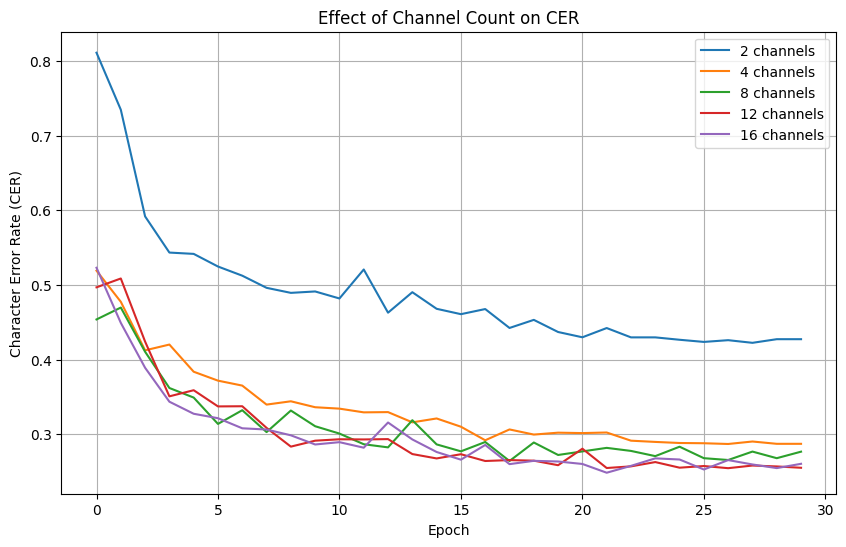

Final CER for different channel counts:
2 channels: 0.4275
4 channels: 0.2874
8 channels: 0.2769
12 channels: 0.2553
16 channels: 0.2606


In [18]:
# Run channel count experiments
channel_counts = [2, 4, 8, 12, 16]  # Test different channel counts
channel_results = test_channel_counts(
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    channel_counts=channel_counts,
    epochs=30  # Use fewer epochs per experiment to save time
)

# Plot results
plt.figure(figsize=(10, 6))
for num_channels, result in channel_results.items():
    plt.plot(result['val_cer'], label=f'{num_channels} channels')
plt.xlabel('Epoch')
plt.ylabel('Character Error Rate (CER)')
plt.title('Effect of Channel Count on CER')
plt.legend()
plt.grid(True)
plt.savefig('channel_count_cer.png')
plt.show()

# Print final CERs
print("Final CER for different channel counts:")
for num_channels, result in channel_results.items():
    print(f"{num_channels} channels: {result['final_cer']:.4f}")

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize the EMGConformer model with better parameters
model = EMGConformer(
    num_classes=99,
    d_model=256,        # Increased from 128 for better representation
    nhead=8,            # Increased from 4 for more attention heads
    num_layers=4,       # Increased from 2 for deeper model
    dropout=0.3         # Reduced from 0.5 to prevent overfitting
)

# Print model architecture and parameter count
print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

# Move the model to the device
model = model.to(device)

# Test with a small batch
try:
    print("Testing model with a small batch...")
    # Get a small batch
    test_batch = next(iter(train_loader))
    test_inputs = test_batch['inputs'].to(device)
    test_lengths = test_batch['input_lengths'].to(device)
    
    # Test forward pass
    with torch.no_grad():
        outputs = model(test_inputs, test_lengths)
    
    print(f"Forward pass successful! Output shape: {outputs.shape}")
    
    # Now try the training
    print("Starting training...")
    history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        epochs=100,      # Train for more epochs
        lr=0.001,        # Better learning rate
        weight_decay=1e-4  # Slightly reduced weight decay
    )
except Exception as e:
    print(f"Error encountered: {type(e).__name__}: {e}")
    
    # Try with small batch only for debugging
    if 'small_train_loader' in globals() and 'small_val_loader' in globals():
        print("Trying with small data loaders for debugging...")
        try:
            history = train_model(
                model=model,
                train_loader=small_train_loader,
                val_loader=small_val_loader,
                device=device,
                epochs=2,  # Just a few epochs
                lr=0.001,
                weight_decay=1e-4
            )
        except Exception as e2:
            print(f"Error with small data loaders: {type(e2).__name__}: {e2}")

In [ ]:
all_predictions_lst = history['all_predictions']
all_targets_lst = history['all_targets']

# Make sure this epoch exists in your history
epoch_id = min(60-1, len(all_predictions_lst)-1)  # Get the last epoch by default
print(f"Using results from epoch {epoch_id}")

# Output how many epochs of predictions we have
print(f"Number of epochs with predictions: {len(all_predictions_lst)}")

# Make sure we have predictions for this epoch
if epoch_id < len(all_predictions_lst) and all_predictions_lst[epoch_id]:
    # Get number of samples and choose one that exists
    num_samples = len(all_predictions_lst[epoch_id])
    it = min(12, num_samples-1)  # Default to sample 12 or the last one if fewer
    
    print(f"Number of samples in epoch {epoch_id}: {num_samples}")
    print(f"Sample {it} prediction: {all_predictions_lst[epoch_id][it]}")
    pred = all_predictions_lst[epoch_id][it]
    
    print(f"Number of targets in epoch {epoch_id}: {len(all_targets_lst[epoch_id])}")
    print(f"Sample {it} target: {all_targets_lst[epoch_id][it]}")
    target = all_targets_lst[epoch_id][it]
    
    # Convert indices to characters
    char_set = charset()
    
    # Filter out null class tokens and duplicates from predictions
    filtered_pred = []
    prev = None
    for p in pred:
        if p != char_set.null_class and p != prev:
            filtered_pred.append(p)
        prev = p
    
    pred_chars = char_set.labels_to_str(filtered_pred)
    target_chars = char_set.labels_to_str(target)
    print(f'prediction: {pred_chars}')
    print(f'target    : {target_chars}')
    
    # Show additional examples
    print("\nAdditional examples:")
    for i in range(5):
        sample_idx = min(i, num_samples-1)
        pred = all_predictions_lst[epoch_id][sample_idx]
        target = all_targets_lst[epoch_id][sample_idx]
        
        # Filter out null class tokens and duplicates
        filtered_pred = []
        prev = None
        for p in pred:
            if p != char_set.null_class and p != prev:
                filtered_pred.append(p)
            prev = p
            
        pred_chars = char_set.labels_to_str(filtered_pred)
        target_chars = char_set.labels_to_str(target)
        print(f'Example {i+1}:')
        print(f'  prediction: {pred_chars}')
        print(f'  target    : {target_chars}')
else:
    print(f"No predictions available for epoch {epoch_id}")